In [1]:
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import glob
from sklearn.externals import joblib

from utility import *
from lane_fitting import *
import os.path as path
from moviepy.editor import VideoFileClip

%matplotlib inline

# Camera calibration
Calibrate camera using opencv library and test the result.

In [3]:
calibration_file_dir = './camera_cal/'
mtx_path = './mtx.pkl'
dist_path = './dist.pkl'

In [4]:
if path.isfile(mtx_path) and path.isfile(dist_path):
    mtx = joblib.load('./mtx.pkl')
    dist = joblib.load('./dist.pkl')
else:
    mtx, dist = calibrate_from_dir(calibration_file_dir, mtx_path, dist_path)

## visualize undistortion process with checkboard image.

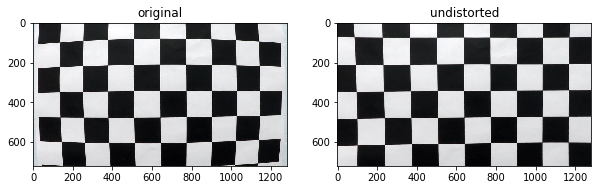

In [5]:
img = cv2.imread(calibration_file_dir+'calibration1.jpg')
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10,20))
ax1.imshow(img)
ax1.set_title('original')
dst = cv2.undistort(img, mtx, dist, None, mtx)
ax2.set_title('undistorted')
ax2.imshow(dst)

# Perspective transform
Get bird's view of the road from camera image

In [4]:
img_list = sorted(glob.glob('./test_images/*.*'))
img_index = 2

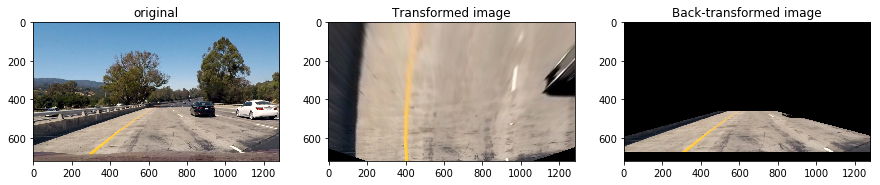

In [5]:
fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(15, 30))

img = cv2.imread(img_list[img_index])
#img = remove_shadow(img)
ax1.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
ax1.set_title('original')

M, warped = get_birdview(img)
ax2.imshow(cv2.cvtColor(warped, cv2.COLOR_BGR2RGB))
ax2.set_title('Transformed image')

Minv = np.linalg.inv(M)
warpedback = cv2.warpPerspective(warped, Minv, 
                                 dsize=warped.shape[1::-1])
ax3.imshow(cv2.cvtColor(warpedback, cv2.COLOR_BGR2RGB))
ax3.set_title('Back-transformed image')

# Binarize image by sobel operator and color thresholding
I tested shadow removal but turned out to be harmful to some examples.  
Guess that's why cnn is so much better; can learn complicative rules.  

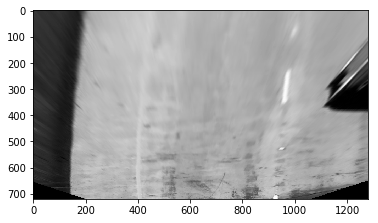

In [6]:
gray = cv2.cvtColor(warped, cv2.COLOR_BGR2GRAY)

plt.imshow(gray, 'gray')

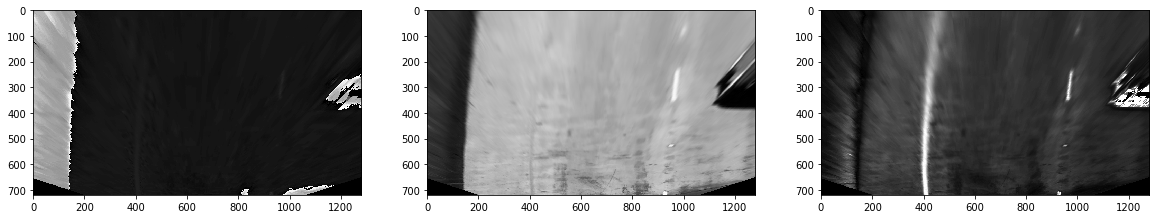

In [7]:
hls = cv2.cvtColor(warped, cv2.COLOR_BGR2HLS)
figure, ax = plt.subplots(1,3, figsize=(20, 30))
for i in range(3):
    ax[i].imshow(hls[..., i], 'gray')

## Add color masks to add robustness to handle challenge movies

43148
35350


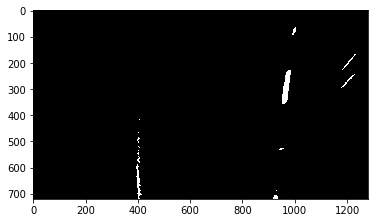

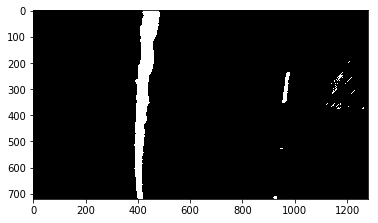

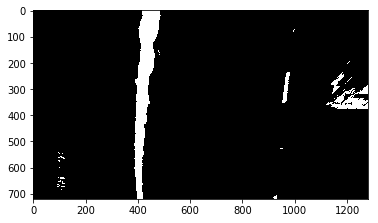

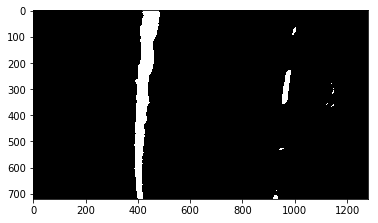

In [10]:
plt.figure()
white = white_mask(warped, sensitivity=50)
plt.imshow(white, 'gray')

plt.figure()
yellow = yellow_mask(hls, sensitivity=150)
plt.imshow(yellow, 'gray')

plt.figure()
chan_mask = np.zeros_like(yellow)
chan_mask[hls[..., 2] > 100] = 1
plt.imshow(chan_mask, 'gray')
print(np.sum(chan_mask))

plt.figure()
color_mask = cv2.bitwise_or(white, yellow)
print (np.sum(color_mask))
#if np.sum(color_mask) > 40000:
#    color_mask = cv2.bitwise_and(color_mask, chan_mask)
#elif np.sum(color_mask) < 10000 and np.sum(chan_mask) < 20000:
#    color_mask = cv2.bitwise_or(color_mask, chan_mask) 
    
color_mask[:, :200] = 0
color_mask[:, 1150:] = 0
plt.imshow(color_mask, 'gray')

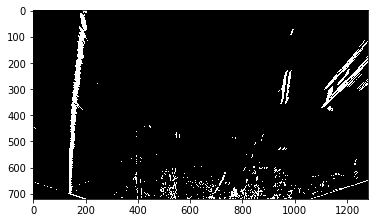

In [23]:
sobel = abs_sobel_thresh(gray, orient='x', sobel_kernel=5, thresh=(25, 255))
# sobel = mag_thresh(gray, thresh=(5, 25))
#combined = np.zeros_like(sobel)|
#combined[(sobel == 1) & (color_mask == 1)] = 1
plt.imshow(sobel, 'gray')
#plt.figure(), plt.imshow(combined, 'gray')

# Sliding window search and polynomial fitting

In [11]:
def binary_mask(gray, hls):   
    white = white_mask(hls, sensitivity=50)
    yellow = yellow_mask(hls, sensitivity=100)
    #chan_mask = np.zeros_like(yellow)
    #chan_mask[hls[..., 2] > 200] = 1
    color_mask = cv2.bitwise_or(white, yellow)
    #if np.sum(color_mask) > 40000:        
    #    color_mask = cv2.bitwise_and(color_mask, chan_mask)
    #elif np.sum(color_mask) < 10000 and np.sum(chan_mask) < 20000:
    #else:
    #    color_mask = cv2.bitwise_or(color_mask, chan_mask)    
    #combined = abs_sobel_thresh(color_mask, 'x', sobel_kernel=5, thresh=(15, 255))
    combined = color_mask
    combined[:, :300] = 0
    combined[:, 1100:] = 0 
    return combined

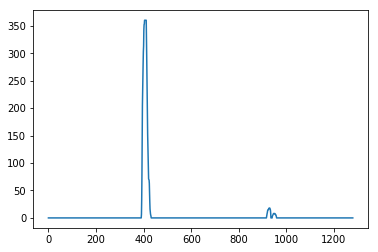

In [12]:
img = binary_mask(gray, hls)
histogram = np.sum(img[img.shape[0]//2:, ...], axis=0)
plt.plot(histogram)

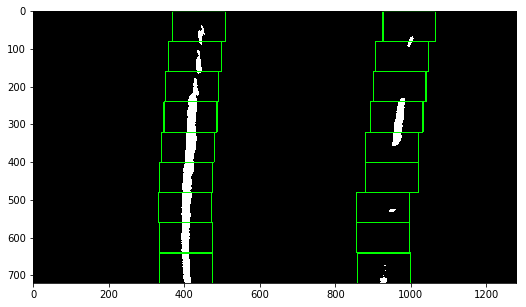

In [13]:
midpoint = np.int(histogram.shape[0]/2)
leftx_base = [np.argmax(histogram[:midpoint])]
rightx_base = [np.argmax(histogram[midpoint:]) + midpoint]

left_ys, left_xs, out, _ = sliding_window(img, leftx_base)
right_ys, right_xs, out, _ = sliding_window(img, rightx_base, out_img=out)
fig = plt.figure(figsize=(10,5))
plt.imshow(out)

In [18]:
# Fit a second order polynomial to each
left_fit = np.polyfit(left_ys, left_xs, 2)
right_fit = np.polyfit(right_ys, right_xs, 2)
loff = left_fit[2]
roff = right_fit[2]

In [19]:
print(left_fit)
print(right_fit)

[ -7.61426670e-05  -5.25418615e-02   4.40184154e+02]
[  2.11794631e-04  -3.10905283e-01   1.02730493e+03]


(720, 0)

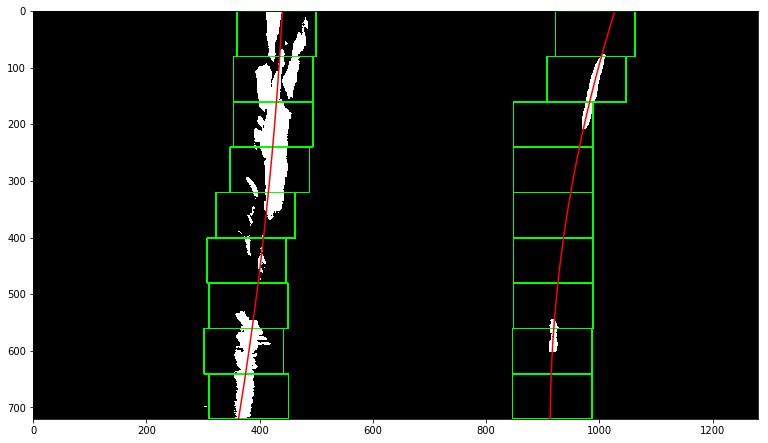

In [20]:
# Generate x and y values for plotting
ploty = np.linspace(0, img.shape[0]-1, img.shape[0] )
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

fig = plt.figure(figsize=(15,7.5))
plt.imshow(out)
plt.plot(left_fitx, ploty, color='red')
plt.plot(right_fitx, ploty, color='red')
plt.xlim(0, 1280)
plt.ylim(720, 0)

Calculate curvature for both lanes

In [21]:
# Define conversions in x and y from pixels space to meters
ym_per_pix = 30/720 # meters per pixel in y dimension
xm_per_pix = 3.7/520 # meters per pixel in x dimension

y_eval = 720
# Fit new polynomials to x,y in world space
left_fit_cr = np.polyfit(left_ys*ym_per_pix, left_xs*xm_per_pix, 2)
right_fit_cr = np.polyfit(right_ys*ym_per_pix, right_xs*xm_per_pix, 2)
# Calculate the new radii of curvature
left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
# Now our radius of curvature is in meters
print(left_curverad, 'm', right_curverad, 'm')
# Example values: 632.1 m    626.2 m

1604.05991701 m 576.016414287 m


Calculate relative car position to lane center

In [22]:
d = car_position_offset(img.shape, left_fit, right_fit, xm_per_pix)
print(d)

-0.0137714121715


Visualize lane fitting

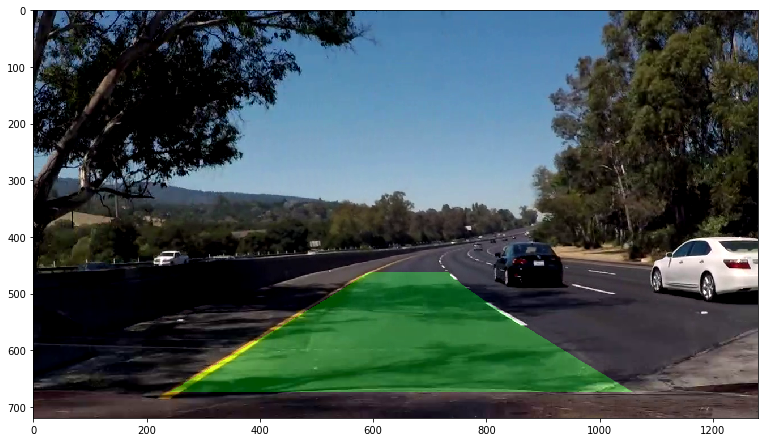

In [23]:
# Create an image to draw the lines on
warp_zero = np.zeros_like(warped[..., 0]).astype(np.uint8)
color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

# Recast the x and y points into usable format for cv2.fillPoly()
pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
pts = np.hstack((pts_left, pts_right))

# Draw the lane onto the warped blank image
cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

# Warp the blank back to original image space using inverse perspective matrix (Minv)
newwarp = cv2.warpPerspective(color_warp, Minv, (img.shape[1], img.shape[0])) 
# Combine the result with the original image
result = cv2.addWeighted(cv2.imread(img_list[img_index]), 1, newwarp, 0.3, 0)
fig = plt.figure(figsize=(15,7.5))
plt.imshow(cv2.cvtColor(result, cv2.COLOR_BGR2RGB))

# Pipeline with example pictures 

In [9]:
def binary_mask(gray, hls): 
    yellow = yellow_mask(hls, sensitivity=150)
    white = white_mask(hls, sensitivity=50)
    chan_mask = np.zeros_like(yellow)
    color_mask = cv2.bitwise_or(white, yellow)
    color_mask[:, :300] = 0
    color_mask[:, 1100:] = 0 
    return color_mask

In [3]:
img_list = sorted(glob.glob('./test_images/*.*'))
for i, file in enumerate(img_list):
    # print(i, flush=True)
    img = cv2.imread(file)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    pipeline = continuous_pipeline(binarize_function=binary_mask)
    out_img = pipeline.pipeline(img, debug=True)
    # fig = plt.figure(i, figsize=(10, 5))
    out_img = cv2.cvtColor(out_img, cv2 .COLOR_RGB2BGR)
    # plt.imshow(out_img)
    cv2.imwrite('./output_images/out_{}.jpg'.format(i), out_img)

# Working with video

In [16]:
#video = './project_video.mp4'
#video = './subset.mp4'
video = './challenge_video.mp4'
clip = VideoFileClip(video)
pipeline = continuous_pipeline(binarize_function=binary_mask, n_buffer=8)
clip_processed = clip.fl_image(pipeline.pipeline)

In [17]:
clip_processed.write_videofile('./result2.mp4', fps=30, audio=False)

[MoviePy] >>>> Building video ./result2.mp4
[MoviePy] Writing video ./result2.mp4


100%|██████████| 485/485 [00:55<00:00,  8.97it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: ./result2.mp4 



In [61]:
img = clip.get_frame(0)
cv2.imwrite('./test_images/challenge1.jpg', img)

True

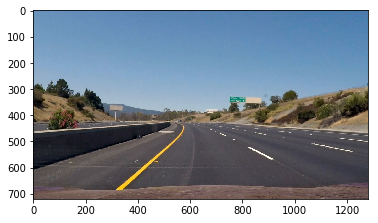

In [7]:
#video = './challenge_video.mp4'
video = './project_video.mp4'
#video = './subset.mp4'
clip = VideoFileClip(video)
img = clip.get_frame(0)
#pipeline = continuous_pipeline()
#out_img = pipeline.pipeline(img)
plt.imshow(img)

In [8]:
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
cv2.imwrite('./test_images/challenge1.jpg', img)

True